In [1]:
%load_ext autoreload
%autoreload 2

In [18]:
import torch

import pandas as pd

import mst
from torch.utils.data import Dataset, DataLoader
from transformers import GPT2Model, GPT2LMHeadModel, GPT2Tokenizer, pipeline

# Load model

In [3]:
model_id = "gpt2"
device = "cuda:5"

model = GPT2LMHeadModel.from_pretrained("logs/jokes/default/model_1epoch")
tokenizer = GPT2Tokenizer.from_pretrained(model_id)

In [4]:
special_tokens = {
    'pad_token': '<|padtoken|>',
    'unk_token': '<|unknowntoken|>'
}
tokenizer.add_special_tokens(special_tokens)
# model.resize_token_embeddings(len(tokenizer))

1

In [5]:
model.to(device)

GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50258, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0): Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): MLP(
          (c_fc): Conv1D()
          (c_proj): Conv1D()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
      (1): Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): Laye

# Load data

In [6]:
class JokesDataset(Dataset):
    def __init__(self, jokes_filepath='data/shortjokes.csv'):
        data = pd.read_csv(jokes_filepath)
        self.jokes = data["Joke"].values
        
    def __len__(self):
        return len(self.jokes)
    
    def __getitem__(self, item):
        return self.jokes[item]

In [7]:
train_data = JokesDataset(jokes_filepath='data/shortjokes/train.csv')
test_data = JokesDataset(jokes_filepath='data/shortjokes/test.csv')
val_data = JokesDataset(jokes_filepath='data/shortjokes/val.csv')

In [8]:
def jokes_collate_fn(batch):
    batch_encoded = tokenizer.batch_encode_plus(
        batch,
        padding='max_length',
        return_tensors='pt',
        max_length=128
    )
    input_ids = batch_encoded['input_ids'].to(device)
    attention_mask = batch_encoded['attention_mask'].to(device)
    labels = input_ids.masked_fill(input_ids == tokenizer.pad_token_id, -100)
    return (input_ids, attention_mask, labels)

In [9]:
train_dataloader = DataLoader(train_data, batch_size=3, shuffle=True, collate_fn=jokes_collate_fn)
val_dataloader = DataLoader(val_data, batch_size=3, collate_fn=jokes_collate_fn)

## Attentions

In [10]:
from tqdm.auto import tqdm

In [11]:
model.train()

GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50258, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0): Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): MLP(
          (c_fc): Conv1D()
          (c_proj): Conv1D()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
      (1): Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): Laye

In [172]:
from utils import generate_sentences

def toploss_reduction(gen_attentions, nat_attentions):
    diff = torch.sum((gen_attentions - nat_attentions)**2) / gen_attentions.shape[0]
    return diff
    
def prepare_attention(attentions, t=0.92):
    return attentions.masked_fill(attentions <= t, 0.0).sum(axis=-1).sum(axis=-1)

def get_generated_attention(model, tokenizer, num_return_sentences):
    generated_sentences = generate_sentences(model, tokenizer, num_return_sequences=num_return_sentences)
    gen_dataloader = DataLoader(generated_sentences, batch_size=3, collate_fn=jokes_collate_fn)
    gen_attentions = []
    for i, batch in enumerate(tqdm(gen_dataloader)):
        input_ids, attention_mask, labels = batch

        output = model(
            input_ids=input_ids.to(device), 
            attention_mask=attention_mask.to(device), 
            labels=input_ids.to(device), 
            output_attentions=True
        )
        gen_attentions.append(
            prepare_attention(
                torch.stack([tensor.to("cpu") for tensor in output.attentions], dim=1)
            )
        )
    gen_attentions = torch.cat(gen_attentions, dim=0)
    return gen_attentions

def plot_head_dist(gen_attentions, nat_attentions, layer=0, head=0):
    fig = plt.figure(figsize=(7, 4))
    plt.hist(gen_attentions[:, layer, head].numpy(), bins=10, label='generated', color='b', alpha=0.5, density=True)
    plt.hist(nat_attentions[:, layer, head].numpy(), bins=10, label='natural', color='r', alpha=0.5, density=True)
    plt.legend()
    plt.title(f"Distribution of natural and generated samples statistics for layer, head: {layer}, {head}")
    return fig

def save_dist_plots(gen_attentions, nat_attentions, bid=0, logdir="logs/jokes/with_toploss/pictures"):
    layers, heads = gen_attentions.shape[1:]
    for layer in range(layers):
        for head in range(heads):
            fig = plot_head_dist(gen_attentions, nat_attentions, layer, head)
            fig.savefig(logdir + '/' + f"n{bid}_l{layer}_h{head}.png")

In [ ]:
def train_model(
        model, 
        tokenizer, 
        train_dataloader, 
        val_dataloader=None,
        epochs=30, 
        logging="logs/jokes/with_toploss", 
        optimizer=None,
        use_labels=False,
        toploss_lambda=1.0):
    """
    Train model with topological loss.
    
    logging: directory for logging results
    """
    if logging is not None:
        writer = SummaryWriter(log_dir=logging)
    if optimizer is None:
        optimizer = AdamW(model.parameters(), lr=3e-5)
        
    nat_attentions = [] # Natural samples attentions
    gen_attentions = [] # Generated samples attentions
    
    for epoch in tqdm(range(epochs), desc="Training on epoch"):
        model.train()
        for i, batch in enumerate(train_dataloader):
            input_ids, attention_mask, labels = batch
            if not use_labels:
                labels = input_ids
            output = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
            
            nat_attentions.append( # save natural attentions
                prepare_attention(
                    torch.stack([tensor.to("cpu") for tensor in output.attentions], dim=1)
                )
            )
            loss = output.loss
            
            if i+1 % 200 == 0:
                nat_attentions = torch.cat(nat_attentions, dim=0)
                gen_attentions = get_generated_attention(model, tokenizer, nat_attentions.shape[0])
                save_dist_plots(gen_attentions, nat_attentions, bid=(i+1)//200, logdir=logging+ "/pictures")
                topological_loss = toploss_reduction(nat_attentions, gen_attentions)
                writer.add_scalar("Train/topological_loss", topological_loss.item(), len(train_dataloader)*epoch + i)
                loss += toploss_lambda*topological_loss
                
                nat_attentions = []
                gen_attentions = []
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            writer.add_scalar("Train/loss", output.loss.cpu().item(), len(train_dataloader)*epoch + i)
        if val_dataloader is not None:
            val_loss = 0.0
            model.eval()
            with torch.no_grad():
                for batch in val_dataloader:
                    input_ids, attention_mask, labels = batch
                    if not use_labels:
                        labels = input_ids
                    output = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
                    val_loss += output.loss.cpu().item()
                writer.add_scalar("Val/loss", val_loss/len(val_dataloader), len(train_dataloader)*epoch)
    return model

In [174]:
from torch.optim import AdamW

optimizer = AdamW(model.parameters(), lr=3e-5)

model.train()
nat_attentions = []

for i, batch in enumerate(tqdm(train_dataloader)):
    input_ids, attention_mask, labels = batch
    output = model(
        input_ids=input_ids.to(device), 
        attention_mask=attention_mask.to(device), 
        labels=input_ids.to(device), 
        output_attentions=True
    )
    nat_attentions.append(
        prepare_attention(
            torch.stack([tensor.to("cpu") for tensor in output.attentions], dim=1)
        )
    )
    if i+1 % 200 == 0:
        optimizer.zero_grad()
        nat_attentions = torch.cat(nat_attentions, dim=0)
        gen_attentions = get_generated_attention(model, tokenizer, attentions.shape[0])
        loss = toploss_reduction(nat_attentions, gen_attentions)
        print(loss.item())
        loss.backward()
        optimizer.step()
        nat_attentions = []
        gen_attentions = []

  0%|          | 0/61775 [00:00<?, ?it/s]

RuntimeError: CUDA out of memory. Tried to allocate 20.00 MiB (GPU 5; 10.92 GiB total capacity; 10.19 GiB already allocated; 13.38 MiB free; 10.24 GiB reserved in total by PyTorch)

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  0%|          | 0/202 [00:00<?, ?it/s]

In [159]:
t = 0.92

t_gen_attentions = gen_attentions.masked_fill(gen_attentions <= t, 0.0).sum(axis=-1).sum(axis=-1)
t_nat_attentions = attentions.masked_fill(attentions <= t, 0.0).sum(axis=-1).sum(axis=-1)

In [166]:
from scipy.stats import wasserstein_distance
import numpy as np

max_ws = 0.0
max_t = 0.0
for t in tqdm([0.85, 0.9, 0.92], desc="Calculation of best threshold"):
    ws = 0.0
    t_gen_attentions = gen_attentions.masked_fill(gen_attentions <= t, 0.0).sum(axis=-1).sum(axis=-1)
    t_nat_attentions = attentions.masked_fill(attentions <= t, 0.0).sum(axis=-1).sum(axis=-1)
    for layer in range(12):
        for head in range(12):
            ws += wasserstein_distance(t_gen_attentions[:, layer, head], t_nat_attentions[:, layer, head])
    if ws >= max_ws:
        max_ws = ws
        max_t = t

Calculation of best threshold:   0%|          | 0/3 [00:00<?, ?it/s]

In [167]:
max_t

0.92

In [168]:
plt.savefig()

526.1641344156595

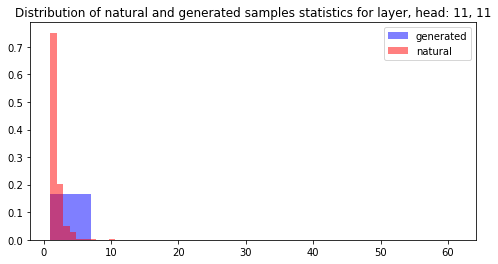

In [189]:
fig = plt.figure(figsize=(8, 4))
plt.hist(t_gen_attentions[:, layer, head].numpy(), bins=10, label='generated', color='b', alpha=0.5, density=True)
plt.hist(t_nat_attentions[:, layer, head].numpy(), bins=10, label='natural', color='r', alpha=0.5, density=True)
plt.legend()
plt.title(f"Distribution of natural and generated samples statistics for layer, head: {layer}, {head}")
plt.show()

In [160]:
import matplotlib.pyplot as plt
import itertools

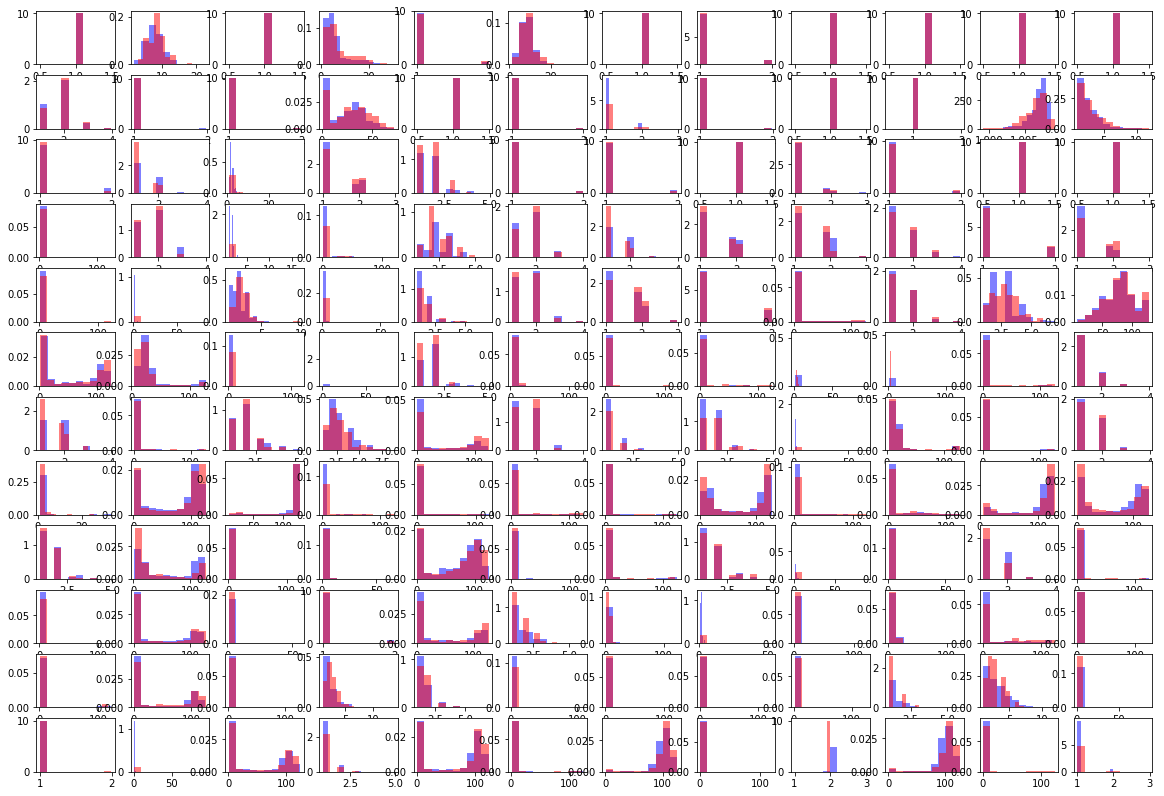

In [161]:
fig, axes = plt.subplots(12, 12, figsize=(20, 14))
for layer in range(12):
    for head in range(12):
        axes[layer, head].hist(
            t_gen_attentions[:, layer, head].numpy(), label='generated', color='b', alpha=0.5, density=True)
        axes[layer, head].hist(
            t_nat_attentions[:, layer, head].numpy(), label='natural', color='r', alpha=0.5, density=True)
plt.show()

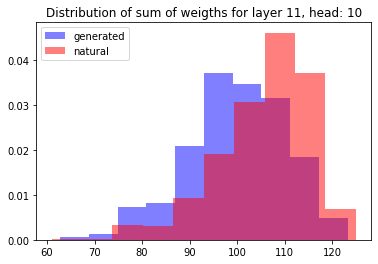

In [158]:
layer, head = 11, 10
plt.title(f"Distribution of sum of weigths for layer {layer}, head: {head}")
plt.hist(t_gen_attentions[:, layer, head].numpy(), label='generated', color='b', alpha=0.5, density=True)
plt.hist(t_nat_attentions[:, layer, head].numpy(), label='natural', color='r', alpha=0.5, density=True)
plt.legend()

In [147]:
t_nat_attentions[:, layer, head].numpy()

array([1.9939898, 1.9562654, 1.997278 , 1.9959375, 1.984893 , 2.9367204,
       2.9661412, 3.9371417, 1.9712801, 2.9497776, 1.9985995, 1.       ,
       1.9892172, 3.9696336, 1.9781568, 1.9591631, 1.9936788, 1.9929774,
       2.9664247, 2.9798496, 1.9964191, 2.968843 , 1.       , 2.9229827,
       1.9898047, 1.997955 , 1.9883647, 1.9936788, 1.9936788, 2.9886637,
       1.9843969, 1.9821315, 1.9781568, 1.9936788, 2.9298458, 1.9936788,
       1.9933503, 1.9964244, 2.9713917, 1.       , 1.9928439, 2.9753366,
       1.999136 , 1.9901681, 1.9986959, 2.9476871, 2.9567761, 1.9972652,
       2.9707582, 1.9985995, 1.997955 , 2.9186532, 1.9849796, 1.999136 ,
       3.9116244, 1.9647647, 1.9963217, 1.9957135, 1.9964191, 2.9489083,
       2.977086 , 1.9762149, 1.9939859, 1.9885232, 1.9964191, 2.97069  ,
       2.9844449, 1.9664536, 1.9882005, 1.9937308, 1.9964191, 1.9949551,
       3.9676938, 1.9851726, 2.9674819, 1.       , 2.9768496, 1.9709549,
       1.982998 , 1.       , 1.962344 , 1.9694439, 

In [59]:
input_attention = attentions[:, -1:, :, :, :]
input_attention.shape

torch.Size([12, 1, 12, 128, 128])

In [69]:
input_attention[0, 0, 0]

tensor([[1.1111, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.9697, 0.1414, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.8246, 0.0835, 0.2031,  ..., 0.0000, 0.0000, 0.0000],
        ...,
        [0.7238, 0.0036, 0.0108,  ..., 0.0000, 0.0000, 0.0000],
        [0.5838, 0.0058, 0.0187,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0048, 0.0141,  ..., 0.0000, 0.0000, 0.0000]],
       grad_fn=<SelectBackward>)

In [ ]:
input_attention = input_attention.to("cuda:7")

In [60]:
import timeit

start = timeit.default_timer()
max_spanning_tree = mst.get_max_spanning_tree(input_attention)
end = timeit.default_timer()

print(f"Calculation for {attentions.shape[0]} samples took: {end-start:.3f}s")

cpu


  0%|          | 0/8128 [00:00<?, ?it/s]

Calculation for 12 samples took: 200.736s


In [35]:
max_spanning_tree.shape

torch.Size([12, 3, 12, 128, 128])

In [62]:
h0s.shape

torch.Size([12, 3, 12])

In [38]:
max_spanning_tree.sum

torch.Size([12, 3, 12, 128, 128])

In [23]:
h0s = max_spanning_tree.sum(dim=-1).sum(dim=-1)

In [33]:
max_spanning_tree.shape

torch.Size([12, 3, 12, 128, 128])

In [32]:
h0s.shape

torch.Size([12, 3, 12])

In [31]:
torch.std(h0s, dim=0).shape

torch.Size([3, 12])

In [28]:
torch.mean(h0s, dim=0)

tensor([[  3.1911,   3.6910,   3.4184,   2.5755,   3.5496,   3.2792,   4.0063,
           3.0805,   2.6583,   3.8076,   3.2682,   2.6972],
        [  3.5372,   5.3188,   3.2141,   2.7414,   4.7527,   3.8032,   3.7762,
           4.1556,   3.1457,   7.1569,   4.2974,   3.1807],
        [  3.1980,  25.3886,   4.5060,   2.7070,   7.0563,   3.5540,   4.9616,
           3.6588,   3.2085,   4.2876,   4.0837,   2.8863],
        [  3.1505,   3.6219,   3.3288,   2.5085,   4.2066,   3.1298,   3.7096,
           2.7236,   3.2625,   3.3735,   3.1044,   2.6908],
        [  3.6177,   7.0066,  10.0629,   2.7952,  11.8636,   6.1610,   7.8385,
           8.2535,   5.0053,   6.2929,   4.7826,   3.6873],
        [  3.4499,   6.4086,   4.4849,   2.7619,   8.3783,   4.2829,  16.7387,
           3.9850,   3.3101,   5.1079,   4.1995,   3.1424],
        [  4.3351, 109.2852,   3.5478,   2.7968,  26.9544,   6.7760,   5.8149,
           4.3693,   4.2125,  12.8915,   5.4334,   3.6087],
        [  3.0327,   3.3597

In [39]:
# torch.combinations(torch.arange(128))

In [63]:
max_spanning_tree.shape

torch.Size([1, 1, 1, 128, 128])

In [64]:
# W = inverted_attentions[-1:, -1:, -1:, :, :]

In [65]:
# W = mst.prepare_weights_batched(W)
# bs, layer, head, n, _ = W.shape
# W = W.reshape(bs*layer*head, n, n)
# W, n = mst.get_edges_from_adj_batched(W)
# adj_matrix = kruskals_pytorch_batched(W, n)
# adj_matrix = adj_matrix.reshape(bs, layer, head, n, n)
# return adj_matrix

cpu


NameError: name 'kruskals_pytorch_batched' is not defined

tensor([[[[[0.0000e+00, 1.0000e+00, 1.0000e+00,  ..., 1.0000e+00,
            1.0000e+00, 1.0000e+00],
           [1.1503e-01, 0.0000e+00, 1.0000e+00,  ..., 1.0000e+00,
            1.0000e+00, 1.0000e+00],
           [5.7943e-01, 8.1541e-01, 0.0000e+00,  ..., 1.0000e+00,
            1.0000e+00, 1.0000e+00],
           ...,
           [9.3328e-01, 9.6053e-01, 9.7153e-01,  ..., 0.0000e+00,
            1.0000e+00, 1.0000e+00],
           [9.3380e-01, 9.6036e-01, 9.7221e-01,  ..., 1.0000e+00,
            0.0000e+00, 1.0000e+00],
           [9.3457e-01, 9.6129e-01, 9.7162e-01,  ..., 1.0000e+00,
            1.0000e+00, 0.0000e+00]],

          [[0.0000e+00, 1.0000e+00, 1.0000e+00,  ..., 1.0000e+00,
            1.0000e+00, 1.0000e+00],
           [9.9266e-01, 0.0000e+00, 1.0000e+00,  ..., 1.0000e+00,
            1.0000e+00, 1.0000e+00],
           [9.9649e-01, 9.8612e-01, 0.0000e+00,  ..., 1.0000e+00,
            1.0000e+00, 1.0000e+00],
           ...,
           [9.4804e-01, 9.3556e-01, 9.5

**Time:**

cpu: 272.447s (400 s with 2nd loop)


cuda: 476s

cpu: 166.896s for 3 layers